## U-Net for Semantic Binary Segmentation for Cuts

Paper Reference: https://arxiv.org/pdf/1505.04597

In [1]:
### Get data from Kaggle
!pip install -q kaggle
!kaggle datasets download -d leoscode/wound-segmentation-images --unzip -p ./wound_data

Dataset URL: https://www.kaggle.com/datasets/leoscode/wound-segmentation-images
License(s): MIT
100% 662M/665M [00:40<00:00, 20.3MB/s]
100% 665M/665M [00:40<00:00, 17.1MB/s]


Import libraries

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

Define Constants

In [18]:
# define consts
IMG_SIZE = 512 # img size used is 512 x 512 px
BATCH_SIZE = 8 # num imgs processed in each iteration
EPOCHS = 20
# limit on num samples
NUM_SAMPLES = 250

# define paths
base_path = "./wound_data/data_wound_seg"
train_images_path = os.path.join(base_path, "train_images")
train_masks_path = os.path.join(base_path, "train_masks")
test_images_path = os.path.join(base_path, "test_images")
test_masks_path = os.path.join(base_path, "test_masks")

Preprocess Data

In [19]:
# function to load and preprocess data
def load_data(image_path, mask_path):
    # read image file and decode to tensor with 3 RGB channels
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    # resize to our size (for testing on other data)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # read mask
    mask = tf.io.read_file(mask_path)
    # decode mask to tensor with single channel
    mask = tf.image.decode_png(mask, channels=1)
    # resize and normalize to range [0, 1]
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask

Create Datasets

In [20]:
# get list of train image files and masks
train_images = sorted(glob(os.path.join(train_images_path, "*.png")))[:NUM_SAMPLES]
train_masks = sorted(glob(os.path.join(train_masks_path, "*.png")))[:NUM_SAMPLES]

# ensure image-mask pairs match by filename
train_pairs = [(img, mask) for img, mask in zip(train_images, train_masks) if os.path.basename(img) == os.path.basename(mask)]
train_images, train_masks = zip(*train_pairs)

test_images = sorted(glob(os.path.join(test_images_path, "*.png")))[:NUM_SAMPLES//5]
test_masks = sorted(glob(os.path.join(test_masks_path, "*.png")))[:NUM_SAMPLES//5]

# ensure image-mask pairs match for test set
test_pairs = [(img, mask) for img, mask in zip(test_images, test_masks) if os.path.basename(img) == os.path.basename(mask)]
test_images, test_masks = zip(*test_pairs)

# create tensorflow datasets
# create dataset from list of tensors, two lists: train_images, and train_masks
train_dataset = tf.data.Dataset.from_tensor_slices((list(train_images), list(train_masks)))

# apply load data (preprocessing) to each element in training data
# AUTOTUNE to automatically determine the num of parallel calls for data loading
train_dataset = train_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

# batch will group the dataset into batches of size BATCH SIZE
# prefetch data to imrpove performance with auto tuning
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((list(test_images), list(test_masks)))
test_dataset = test_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Define the U-Net (Simplified) Model

In [21]:
# define the unet (simplified) model
# input sizes and channels

# NOTE: original paper uses 4 encoder and 4 decoder, for simplicity i only used 3, still playing with the params and layers
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    # input layer
    inputs = layers.Input(input_size)

    # encoder -- 3 conv layers and max pooling after (should be 4 blocks of these)
    # param 1: num of filters, param 2: kernel size (3x3), param 3: activation function, param 4: padding to keep spatial dimensions constant

    # first encoder block
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # second encoder block
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # third encoder block
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # bridge before the decoder
    conv5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(pool4)
    conv5 = layers.Conv2D(1024, 3, activation="relu", padding="same")(conv5)

    # decoder -- use upsampling to expand back to original image size,
    # and concatenate previous layer output with skip features (from encoder before max pooling)

    # first decoder block
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, 3, activation="relu", padding="same")(up6)
    conv6 = layers.Conv2D(512, 3, activation="relu", padding="same")(conv6)

    # second decoder block
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation="relu", padding="same")(up7)
    conv7 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv7)

    # third decoder block
    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation="relu", padding="same")(up8)
    conv8 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv8)

    # fourth decoder block
    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation="relu", padding="same")(up9)
    conv9 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv9)

    # output layer -- 1 filter for the single output channel, need to output one probability value per pixel (likelihood of belonging to the ROI), kernel 1x1 for pixel wise operation
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Training Evaluation

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.9339 - loss: 0.4109 - mean_io_u_2: 0.4878 - val_accuracy: 0.9889 - val_loss: 0.0756 - val_mean_io_u_2: 0.4945
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9883 - loss: 0.0726 - mean_io_u_2: 0.4878 - val_accuracy: 0.9889 - val_loss: 0.0569 - val_mean_io_u_2: 0.4945
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9883 - loss: 0.0577 - mean_io_u_2: 0.4878 - val_accuracy: 0.9889 - val_loss: 0.0486 - val_mean_io_u_2: 0.4945
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9883 - loss: 0.0537 - mean_io_u_2: 0.4878 - val_accuracy: 0.9889 - val_loss: 0.0448 - val_mean_io_u_2: 0.4945
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9883 - loss: 0.0492 - mean_io_u_2: 0.4878 - val_accuracy: 0.9889 - val_loss: 0.0423 - val_mean_io_u_2: 0.4945
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9883 - loss: 0.0466 - mean_io_u_2: 0.4878 - val_accuracy: 0.9889 

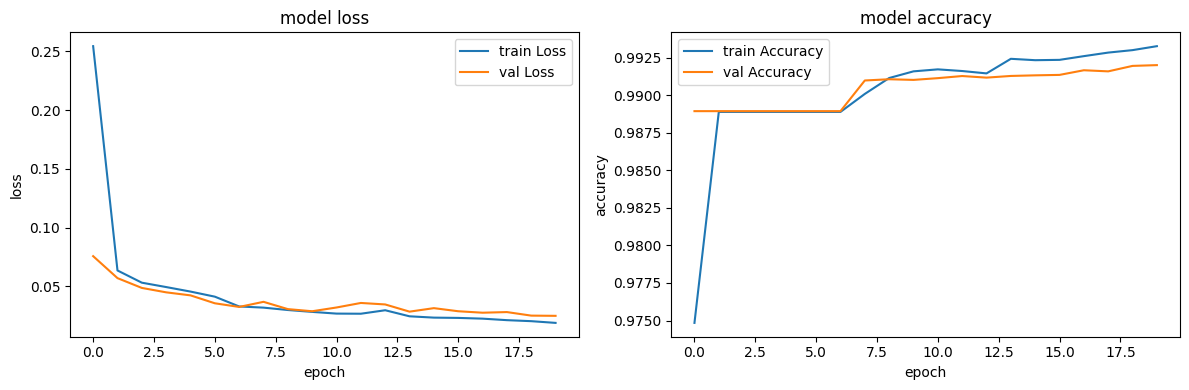

In [22]:
# create and compile the model
model = unet_model()

# compile with loss, metrics, etc.
# adam optimizer with lr 1e-3 i think
# binary crossentropy instead of categorical since 0 or 1 (background or cut) segmentation
# Mean intersection over Union -- computes IoU for each class (degree of overlap btw predicted region (segmentation mask) and actual location), takes the mean across all classes

# increase learning rate
lr = 1e-4
#model.compile("Adam", loss="binary_crossentropy", metrics=["accuracy", MeanIoU(num_classes=2)])
model.compile(optimizer=Adam(learning_rate=lr), loss="binary_crossentropy", metrics=["accuracy", MeanIoU(num_classes=2)])

# train the model
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

# plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='train Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='train Accuracy')
plt.plot(history.history['val_accuracy'], label='val Accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


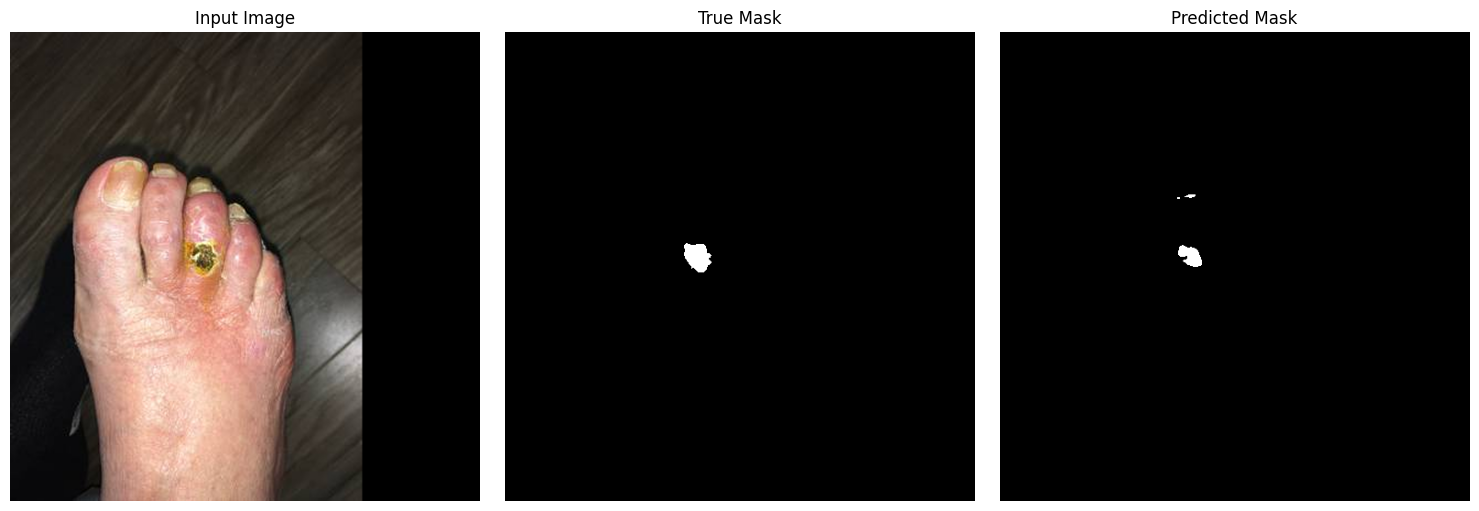

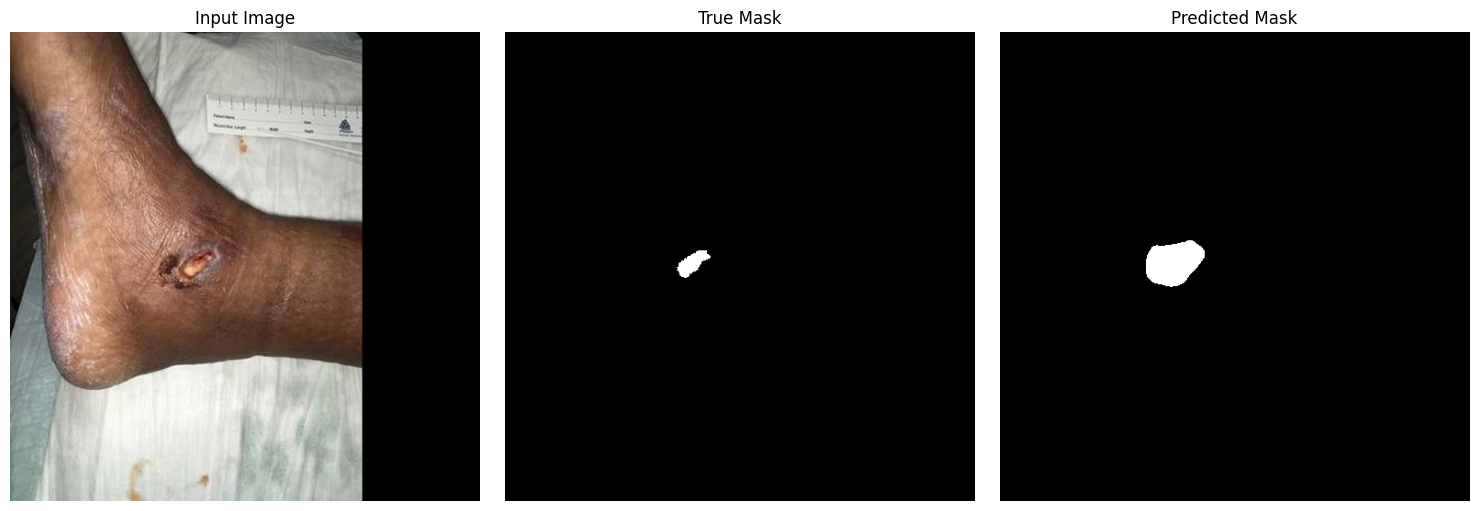

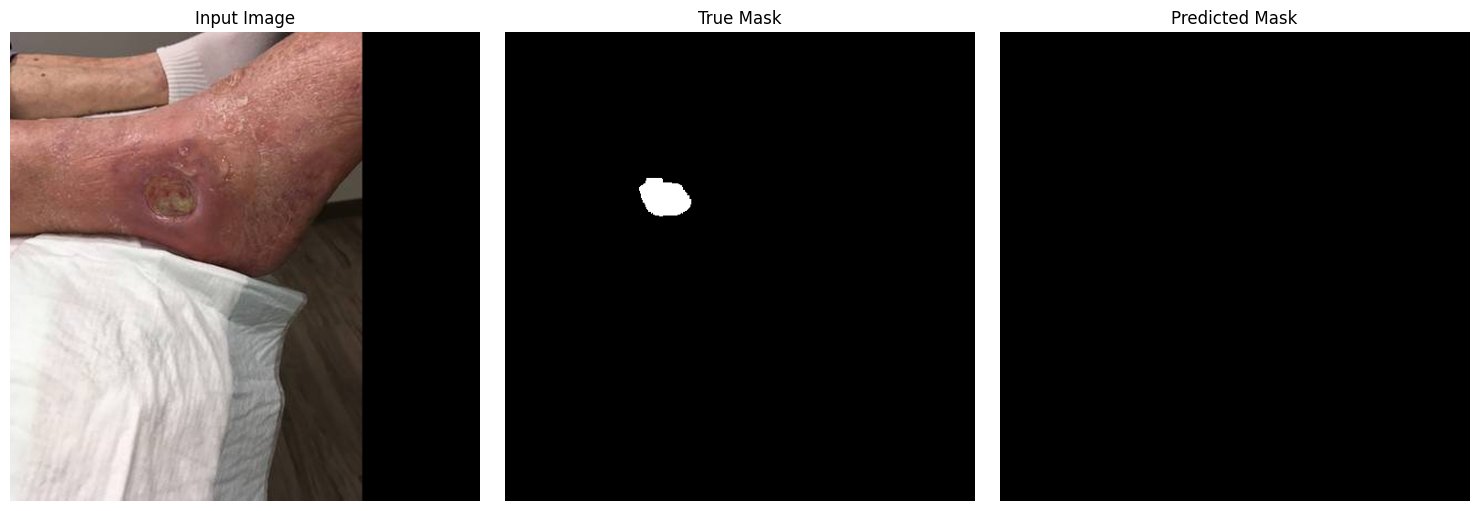

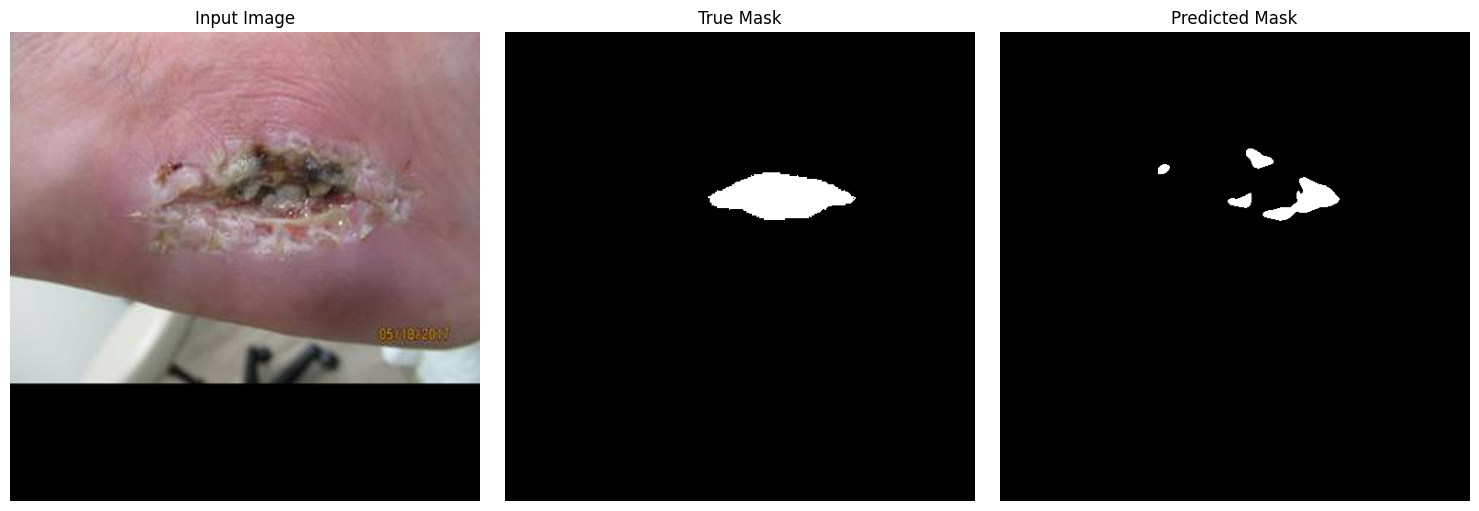

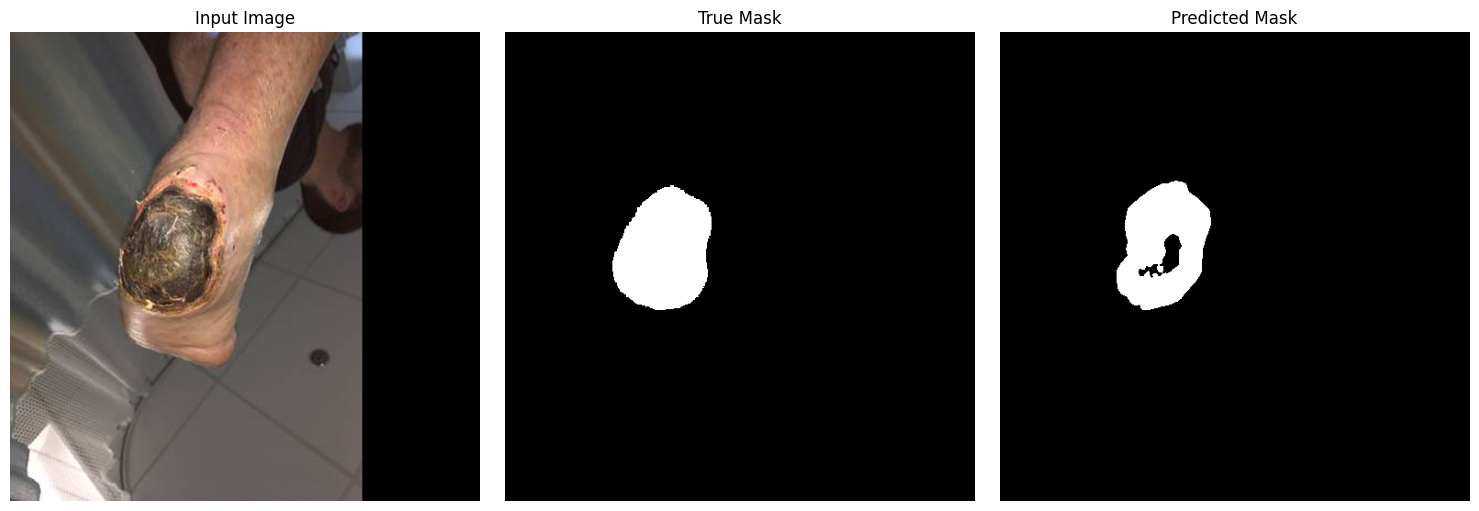

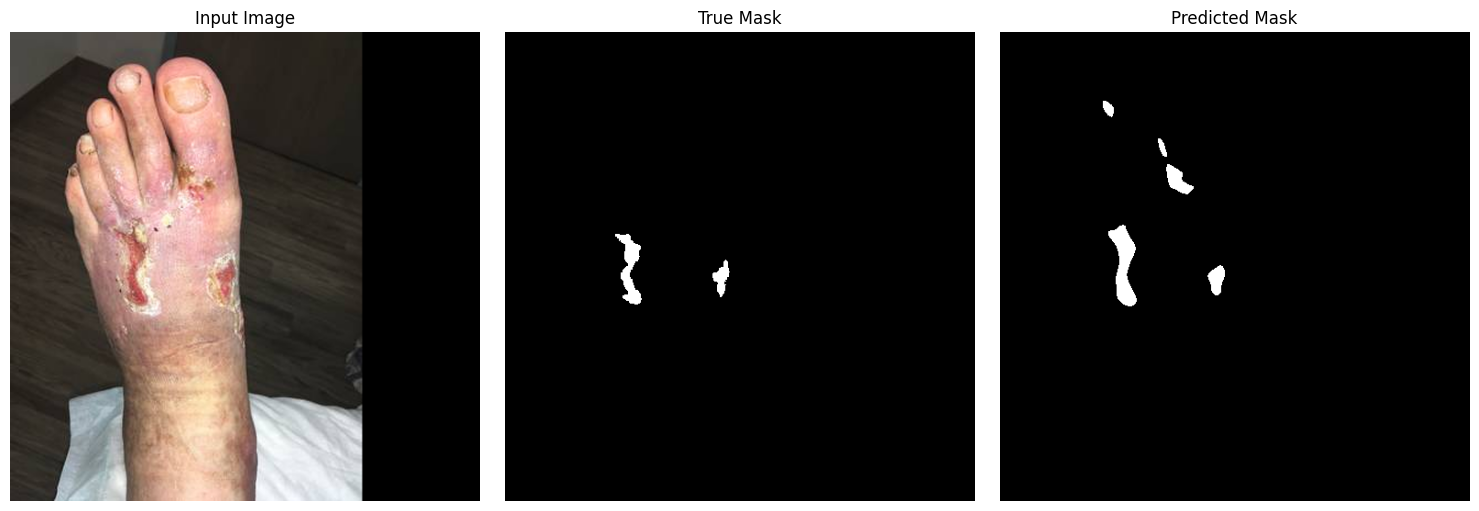

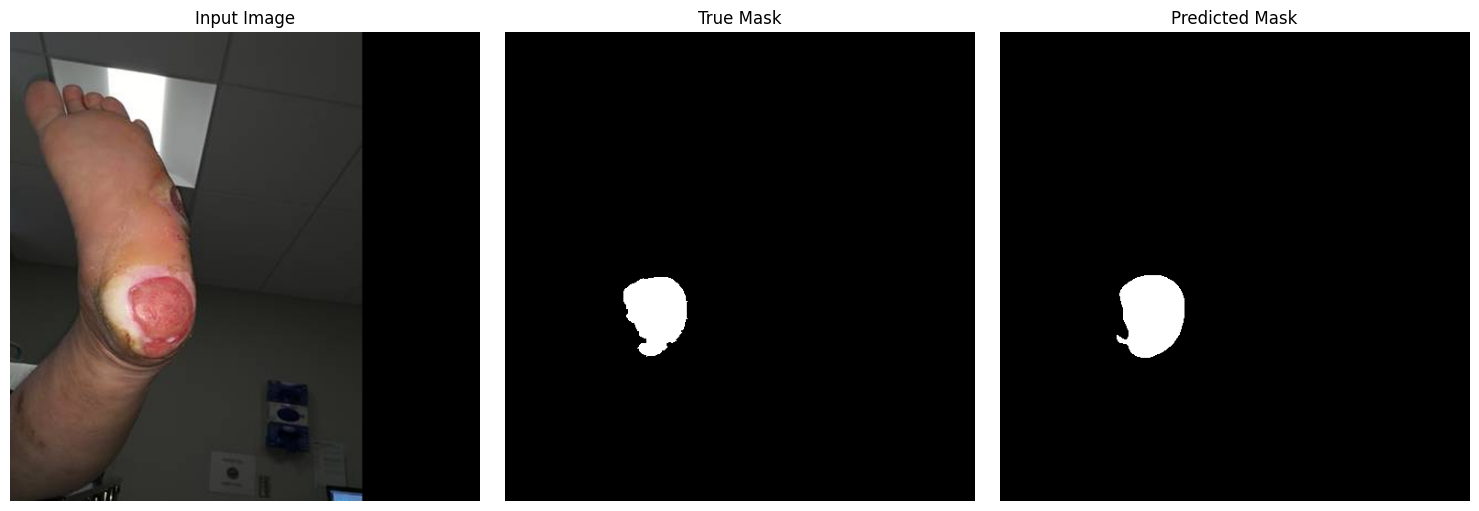

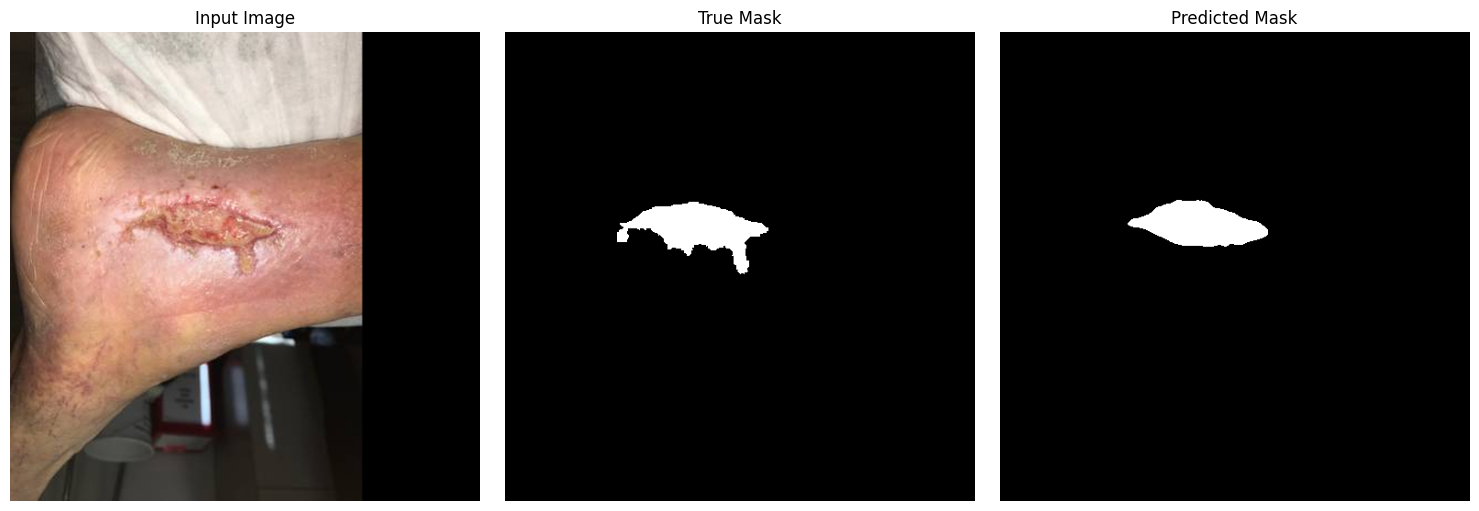

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


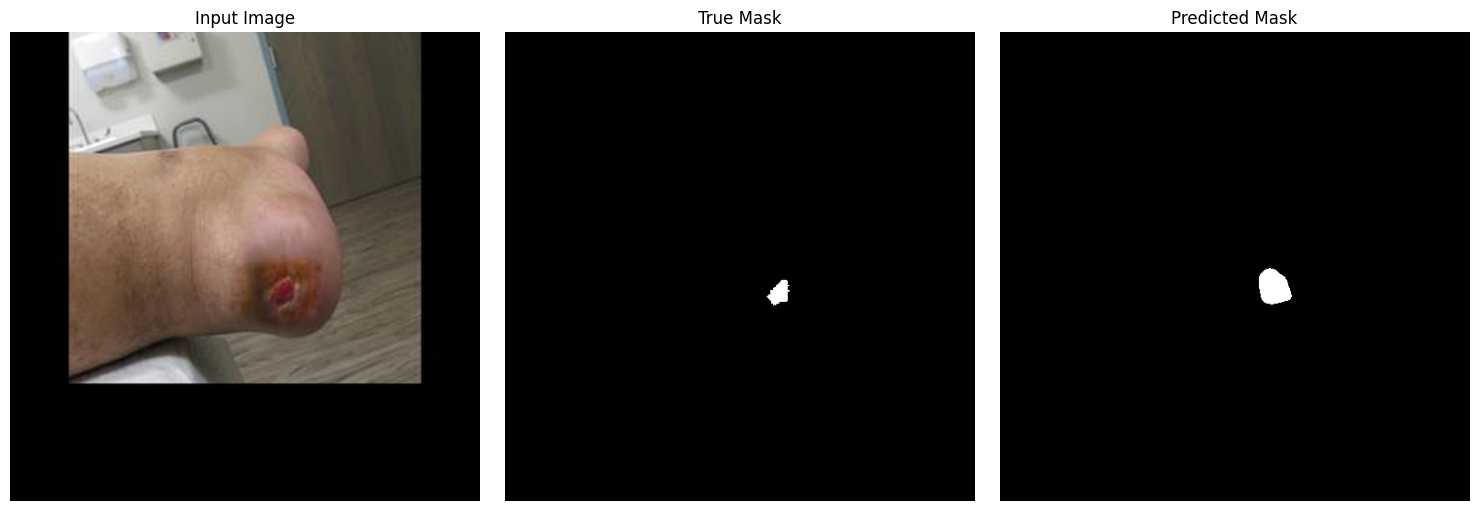

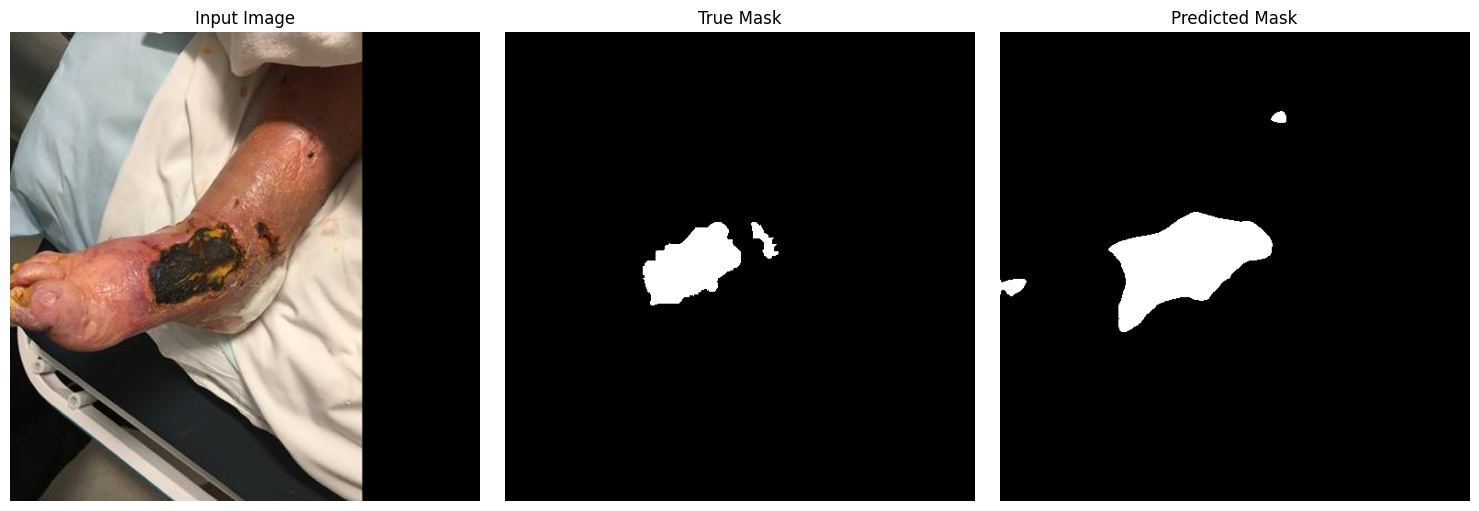

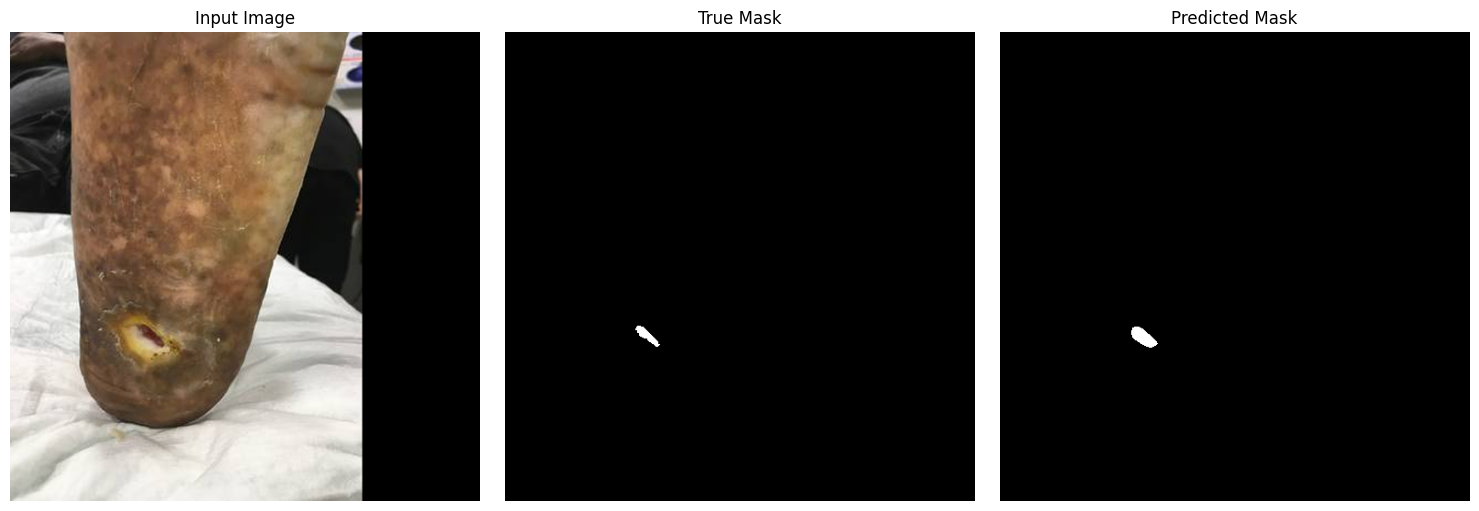

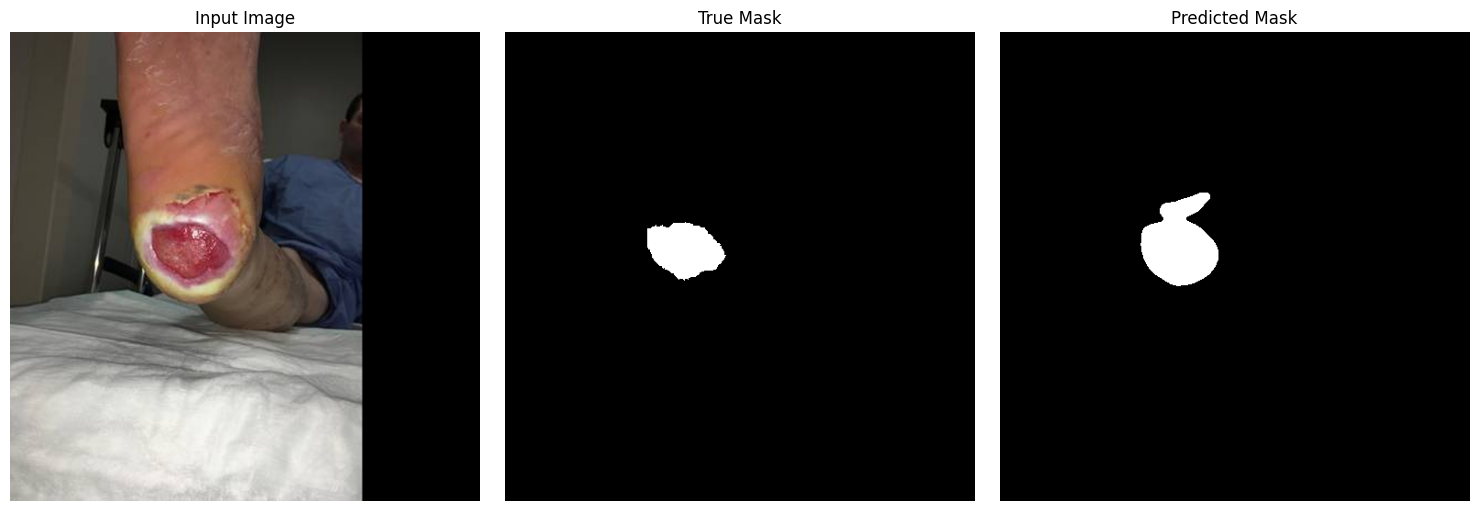

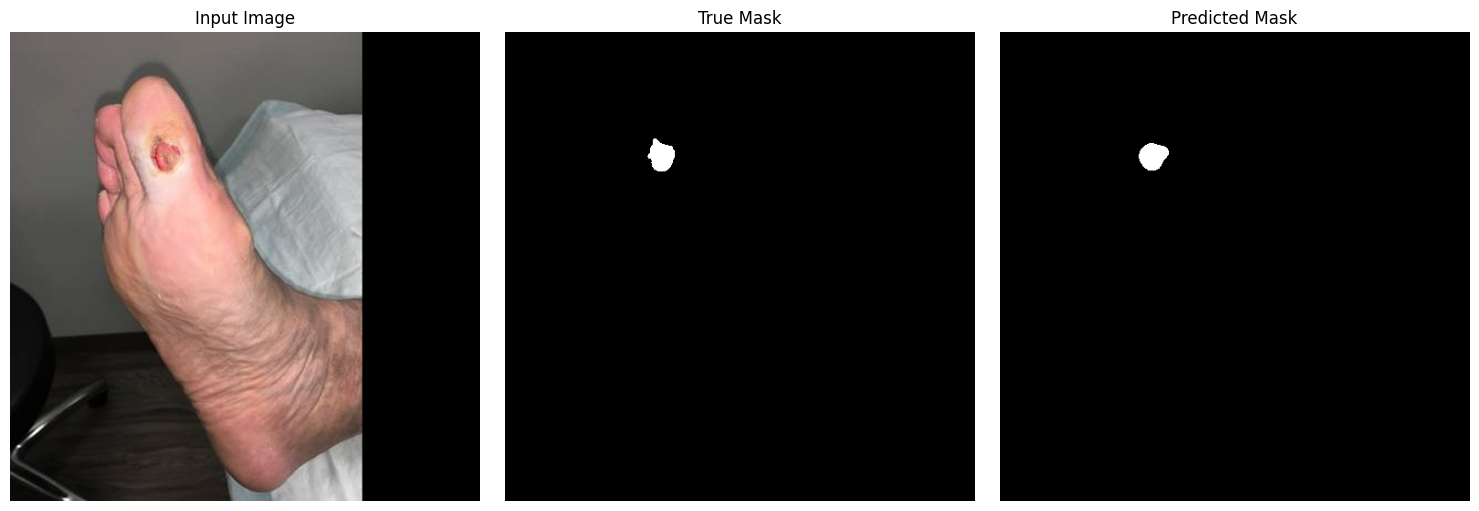

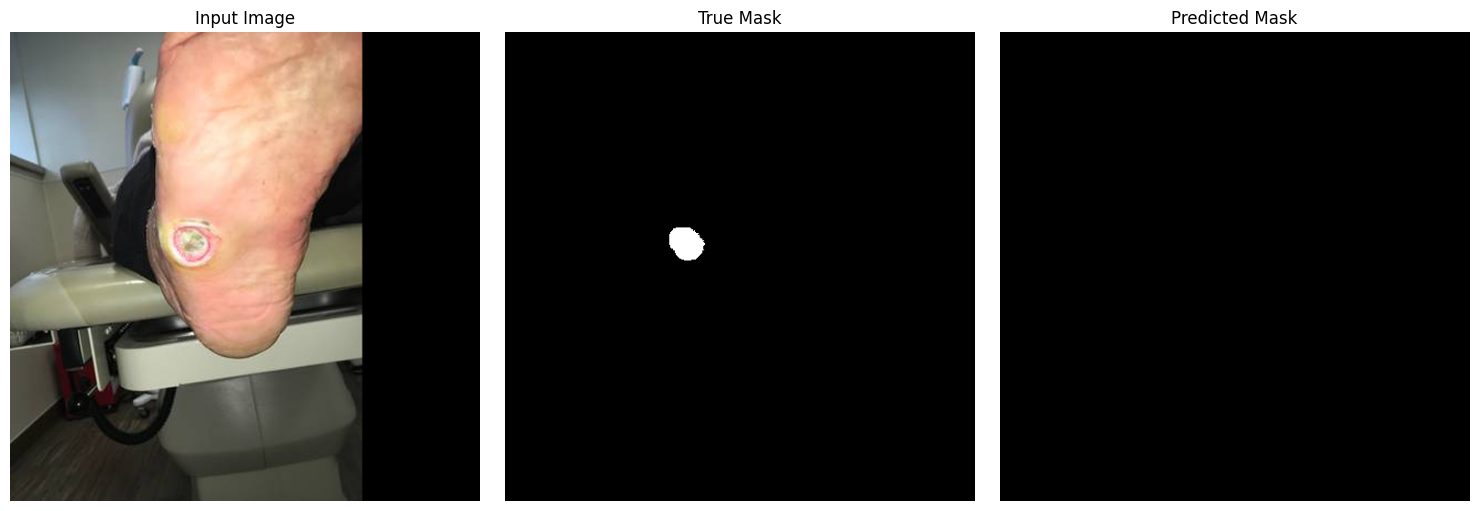

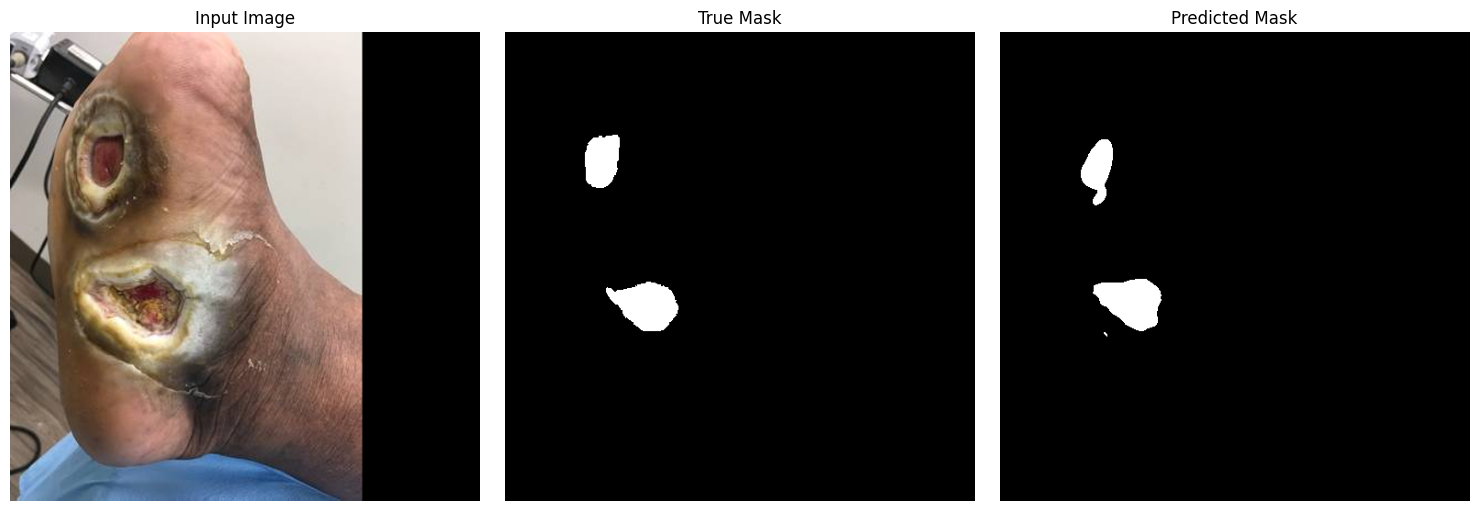

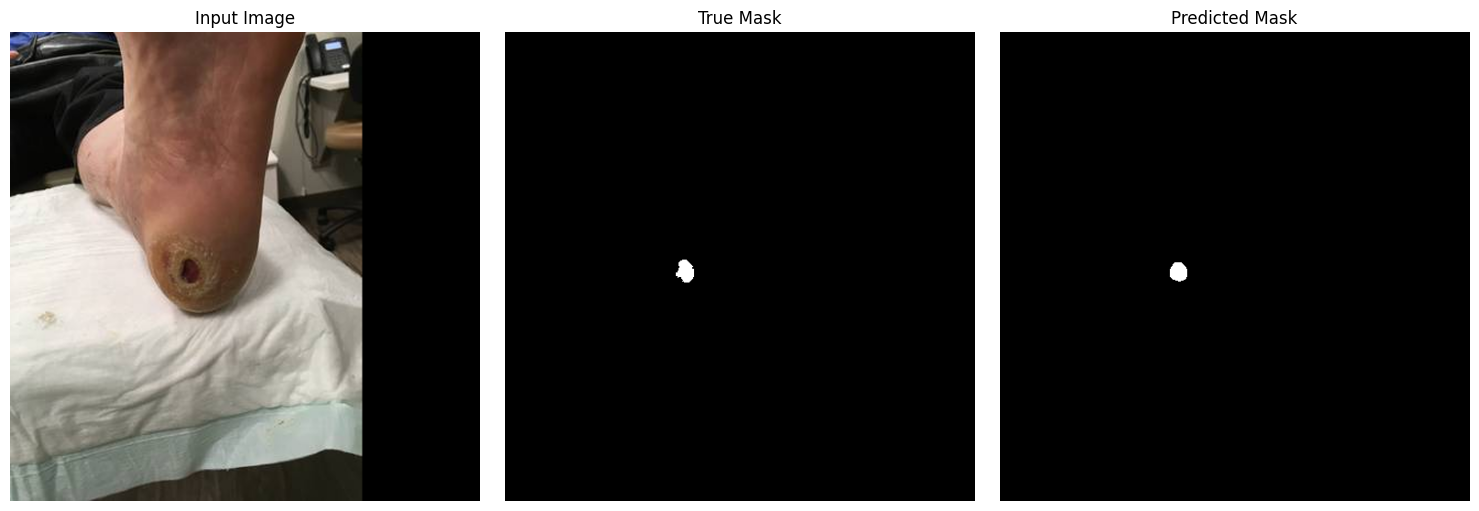

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


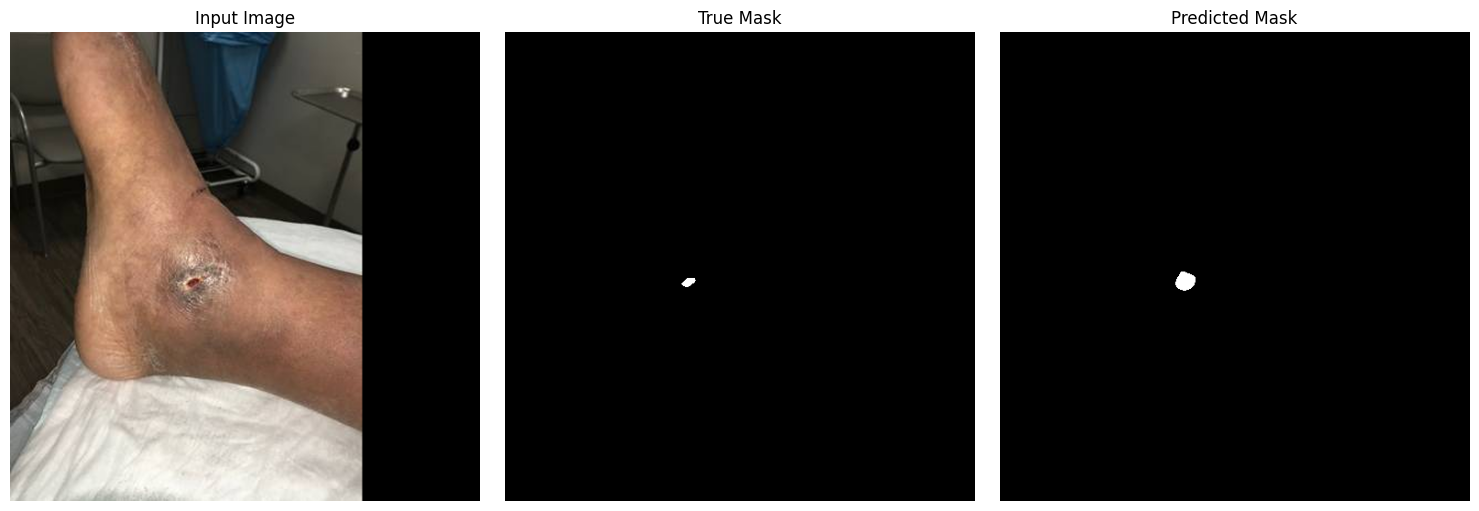

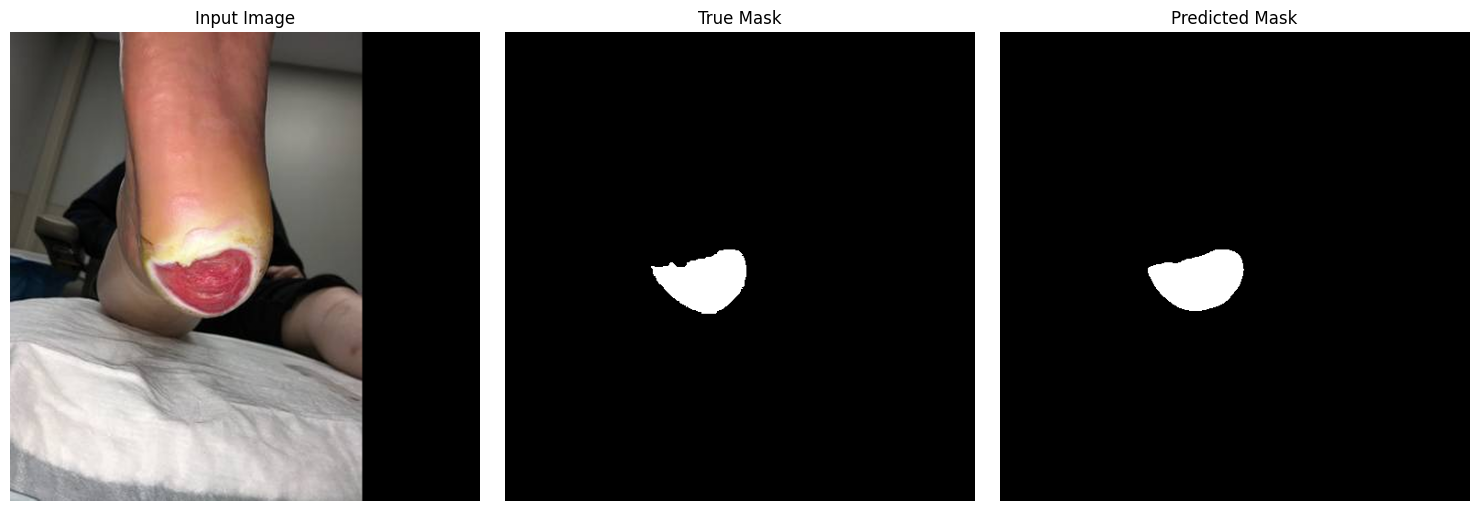

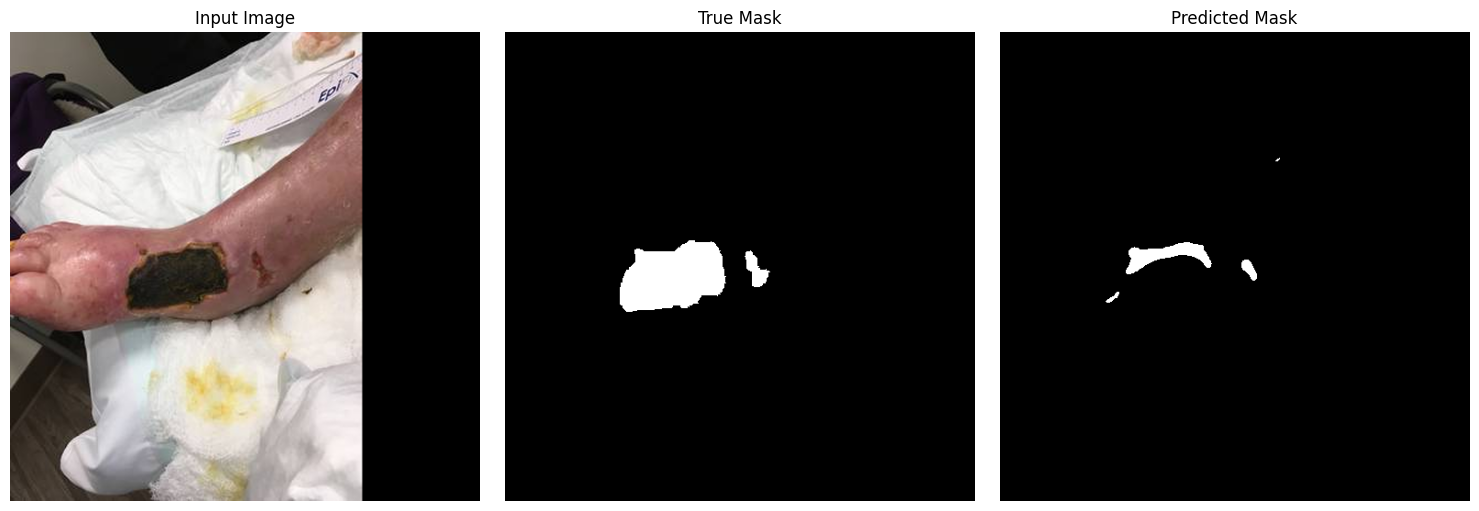

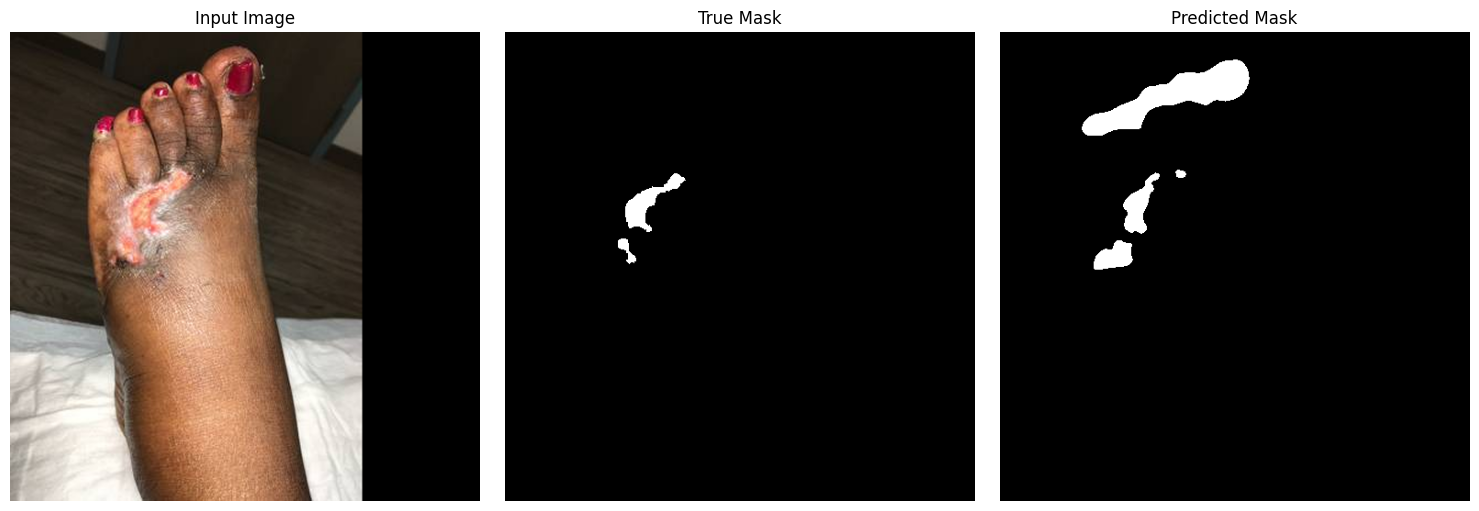

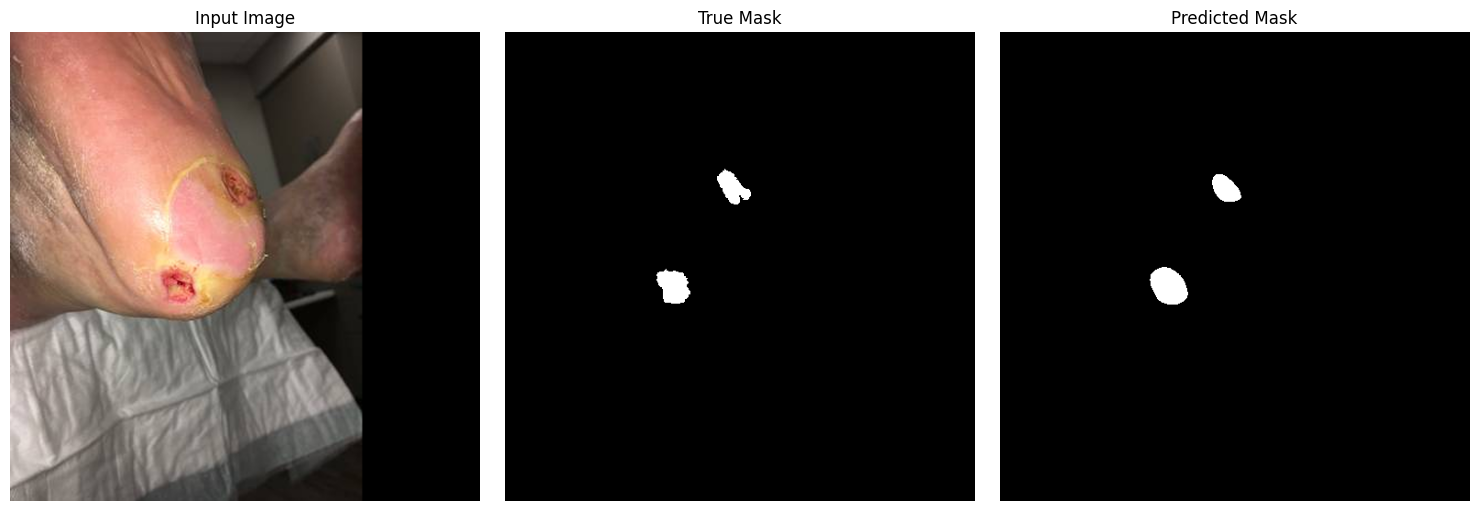

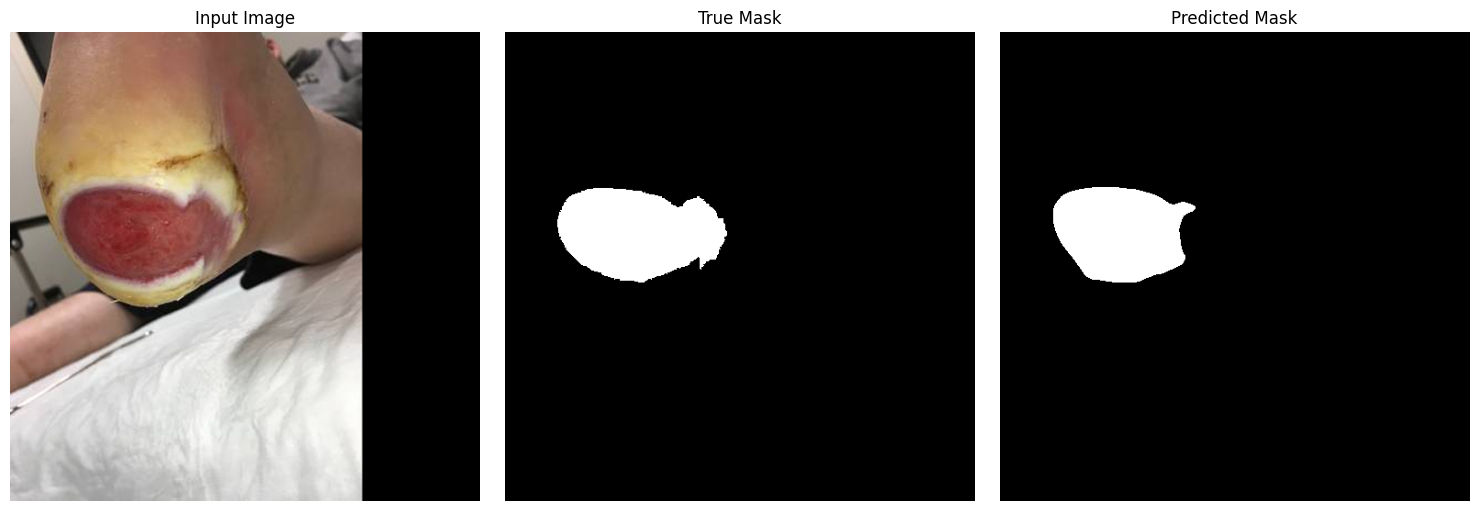

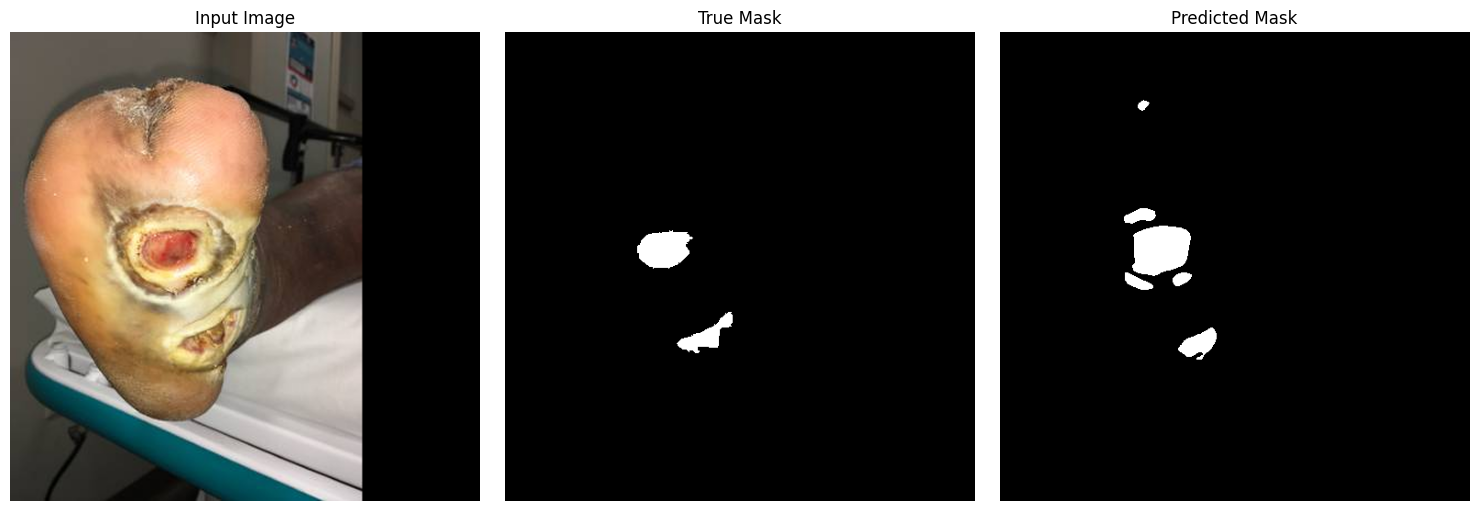

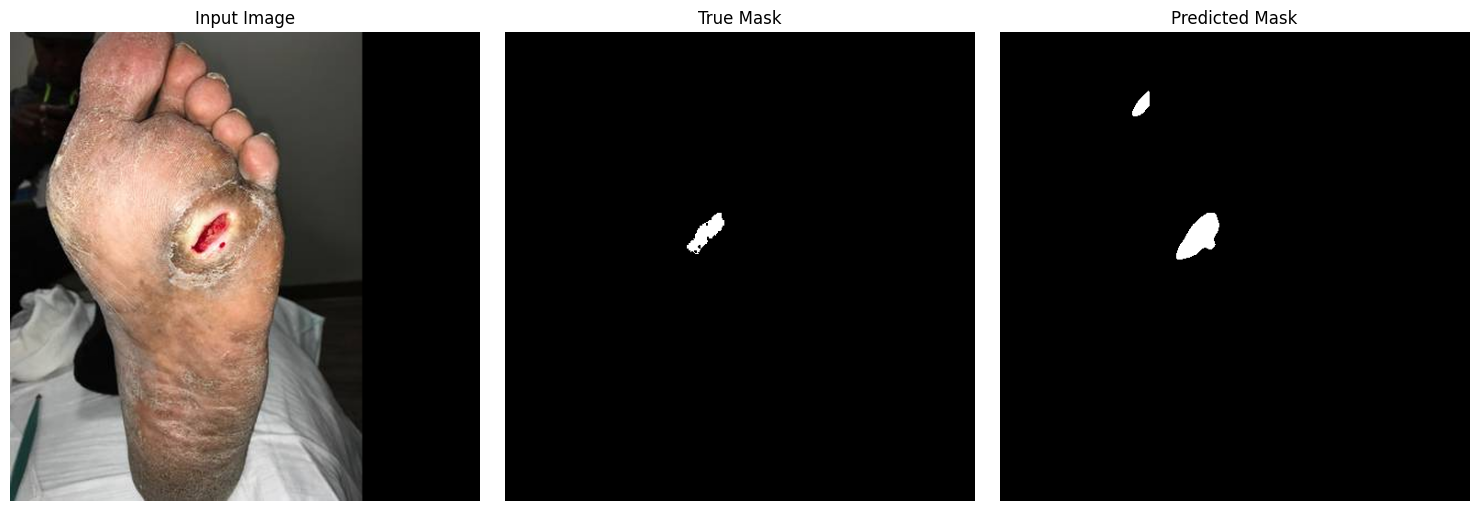

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


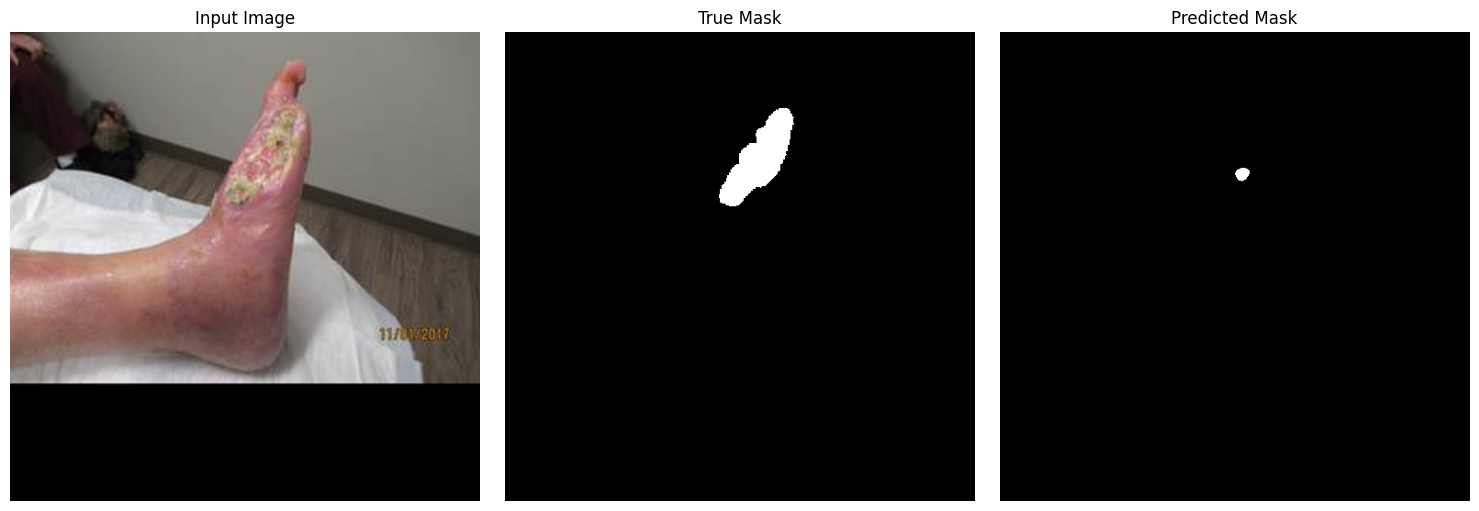

In [23]:
# visualize predictions
def visualize_predictions(model, dataset, num_images=25):
    images_seen = 0
    for images, masks in dataset:
        predictions = model.predict(images)
        for i in range(len(images)):
            if images_seen >= num_images:
                return
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(images[i])
            plt.title('Input Image')
            plt.axis('off')
            plt.subplot(132)
            plt.imshow(masks[i, ..., 0], cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            plt.subplot(133)
            plt.imshow(predictions[i, ..., 0] > 0.18, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            images_seen += 1
        if images_seen >= num_images:
            break

visualize_predictions(model, test_dataset)

Save Model and Log

In [24]:
# save the model
model.save('wound_segmentation_model.h5')

# print some model summary and dataset info
print("\nmodel Summary:")
model.summary()

# print sample sizes again
print(f"\ntraining samples: {len(train_images)}")
print(f"testing samples: {len(test_images)}")


model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 512, 512, 64)   │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 256, 256, 64)   │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 128, 128, 128)  │              0 │ conv2d_60[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 128, 128, 256)  │        590,080 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 64, 64, 256)    │              0 │ conv2d_62[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 32, 32, 512)    │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_12          │ (None, 64, 64, 1024)   │              0 │ conv2d_66[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12       

 Total params: 94,136,837 (359.10 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,757,892 (239.40 MB)


training samples: 250
testing samples: 50
